In [3]:
!mamba install geopandas
!conda install -c conda-forge scikit-image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic, mark_boundaries
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics import jaccard_score

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 2.234 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas, scikit-image
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.2171999999880792 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ imageio                       2.37.0                        pyhfb79c49_0                  conda-forge                   
+ importlib-metadata            8.7.0                         pyhe01879c_1                  conda-forge                   
+ lazy_loader                   0.4

In [9]:
# 1. СОЗДАЁМ СИНТЕТИЧЕСКОЕ ИЗОБРАЖЕНИЕ

np.random.seed(42)
size = 200

# Создаём RGB изображение
img = np.zeros((size, size, 3), dtype=np.uint8)

# Фон (зеленовато-коричневый)
img[:, :, 0] = 120 + np.random.normal(0, 20, (size, size))  # R
img[:, :, 1] = 100 + np.random.normal(0, 20, (size, size))  # G
img[:, :, 2] = 80 + np.random.normal(0, 15, (size, size))   # B

# Добавляем "воду" (синие области)
# Несколько круглых озёр
for _ in range(3):
    center_x = np.random.randint(40, 160)
    center_y = np.random.randint(40, 160)
    radius = np.random.randint(15, 30)
    
    for i in range(size):
        for j in range(size):
            if (i - center_x)**2 + (j - center_y)**2 < radius**2:
                img[i, j, 0] = 30 + np.random.normal(0, 5)   # мало красного
                img[i, j, 1] = 50 + np.random.normal(0, 5)   # мало зелёного
                img[i, j, 2] = 200 + np.random.normal(0, 10) # много синего

# Добавляем линейный объект (река)
for i in range(70, 130):
    for j in range(80, 120):
        if abs(i - 100) < 3 + 5*np.sin(j/10):
            img[i, j, 0] = 25
            img[i, j, 1] = 45
            img[i, j, 2] = 210

# Нормируем значения
img = np.clip(img, 0, 255).astype(np.uint8)

In [11]:
# 2. СОЗДАЁМ "РУЧНУЮ" МАСКУ ДЛЯ СРАВНЕНИЯ

manual_mask = np.zeros((size, size), dtype=int)

# Вода: где синий канал > красного и зелёного
blue_dominant = (img[:, :, 2] > img[:, :, 0] + 30) & (img[:, :, 2] > img[:, :, 1] + 30)
manual_mask[blue_dominant] = 1

# Морфологическая обработка (заполнение дыр)
structure = np.ones((3, 3))
labeled, _ = label(manual_mask)
for i in range(1, labeled.max() + 1):
    if np.sum(labeled == i) > 100:  # только большие объекты
        manual_mask[labeled == i] = 1

print("Ручная маска создана")


# 3. СЕГМЕНТАЦИЯ МЕТОДОМ K-MEANS


# Подготавливаем данные для K-means
h, w, c = img.shape
img_reshaped = img.reshape(-1, 3).astype(np.float32)

# Нормализация
img_reshaped = img_reshaped / 255.0

# K-means с 4 кластерами
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(img_reshaped)
labels_kmeans = labels_kmeans.reshape(h, w)

# Определяем, какой кластер соответствует воде
# Вода имеет высокий синий канал
cluster_centers = kmeans.cluster_centers_ * 255
blue_component = cluster_centers[:, 2]
water_cluster = np.argmax(blue_component)

kmeans_water = (labels_kmeans == water_cluster)

<class 'NameError'>: name 'label' is not defined

In [12]:
# 4. ПРОСТАЯ СЕГМЕНТАЦИЯ ПО ПОРОГУ


# Используем разность каналов (синий - красный)
blue_minus_red = img[:, :, 2].astype(float) - img[:, :, 0].astype(float)

# Находим порог
threshold = np.percentile(blue_minus_red, 85)  # верхние 15%
threshold_seg = blue_minus_red > threshold

# Морфологическая очистка
from scipy.ndimage import binary_opening, binary_closing

# Открытие (убирает шум)
threshold_cleaned = binary_opening(threshold_seg, structure=np.ones((3, 3)))
# Закрытие (заполняет дыры)
threshold_final = binary_closing(threshold_cleaned, structure=np.ones((5, 5)))


# 5. ОЦЕНКА КАЧЕСТВА


# Преобразуем в одномерные массивы для сравнения
manual_flat = manual_mask.flatten()
kmeans_flat = kmeans_water.flatten()
threshold_flat = threshold_final.flatten()

# Метрики для K-means
iou_kmeans = jaccard_score(manual_flat, kmeans_flat)
accuracy_kmeans = np.mean(manual_flat == kmeans_flat)
precision_kmeans = np.sum((manual_flat == 1) & (kmeans_flat == 1)) / (np.sum(kmeans_flat == 1) + 1e-10)
recall_kmeans = np.sum((manual_flat == 1) & (kmeans_flat == 1)) / (np.sum(manual_flat == 1) + 1e-10)

# Метрики для пороговой сегментации
iou_threshold = jaccard_score(manual_flat, threshold_flat)
accuracy_threshold = np.mean(manual_flat == threshold_flat)
precision_threshold = np.sum((manual_flat == 1) & (threshold_flat == 1)) / (np.sum(threshold_flat == 1) + 1e-10)
recall_threshold = np.sum((manual_flat == 1) & (threshold_flat == 1)) / (np.sum(manual_flat == 1) + 1e-10)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ СЕГМЕНТАЦИИ")
print("="*60)
print(f"\n--- K-means кластеризация ---")
print(f"IoU (Intersection over Union): {iou_kmeans:.3f}")
print(f"Accuracy: {accuracy_kmeans:.3f}")
print(f"Precision: {precision_kmeans:.3f}")
print(f"Recall: {recall_kmeans:.3f}")

print(f"\n--- Пороговая сегментация ---")
print(f"IoU (Intersection over Union): {iou_threshold:.3f}")
print(f"Accuracy: {accuracy_threshold:.3f}")
print(f"Precision: {precision_threshold:.3f}")
print(f"Recall: {recall_threshold:.3f}")


РЕЗУЛЬТАТЫ СЕГМЕНТАЦИИ

--- K-means кластеризация ---
IoU (Intersection over Union): 0.123
Accuracy: 0.468
Precision: 0.125
Recall: 0.842

--- Пороговая сегментация ---
IoU (Intersection over Union): 0.994
Accuracy: 0.999
Precision: 0.998
Recall: 0.995


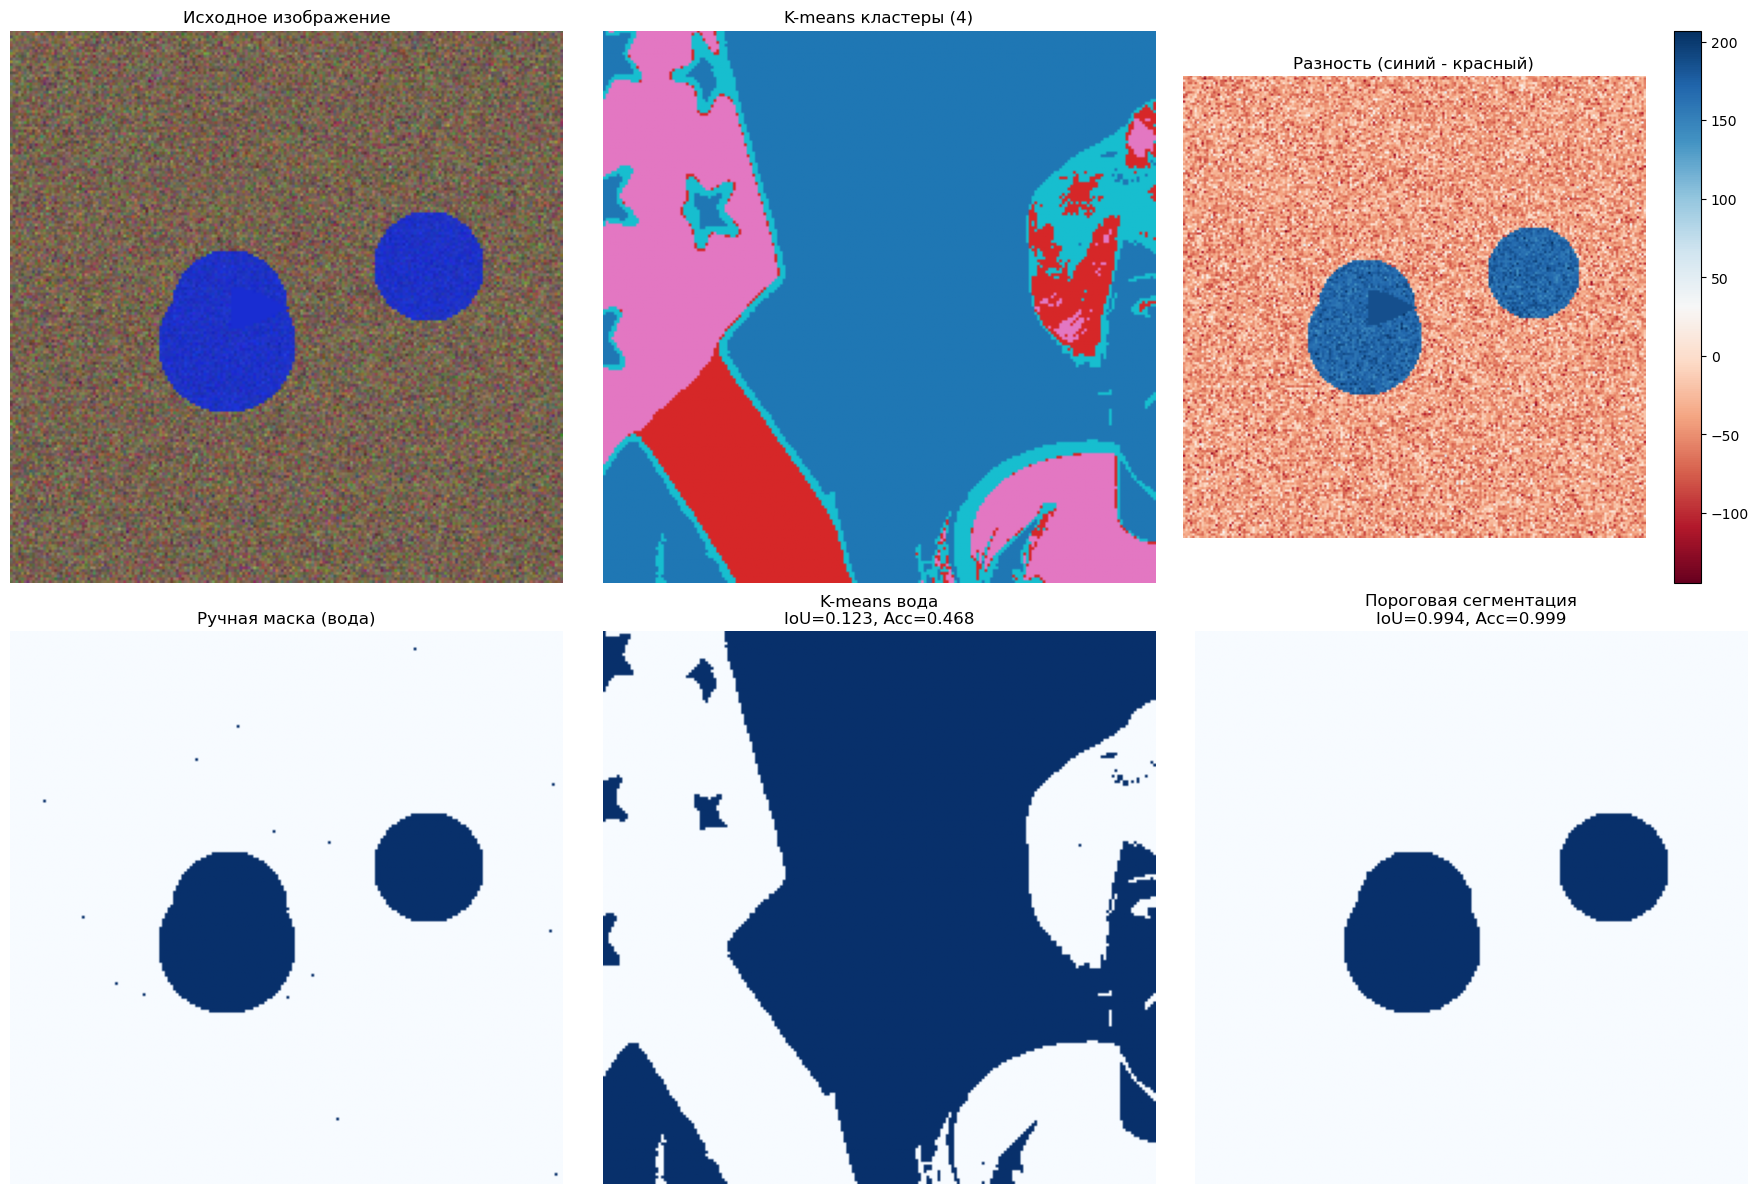


АНАЛИЗ ОШИБОК для метода пороговый
Ложноположительные пиксели: 7 (0.02%)
Ложноотрицательные пиксели: 16 (0.04%)


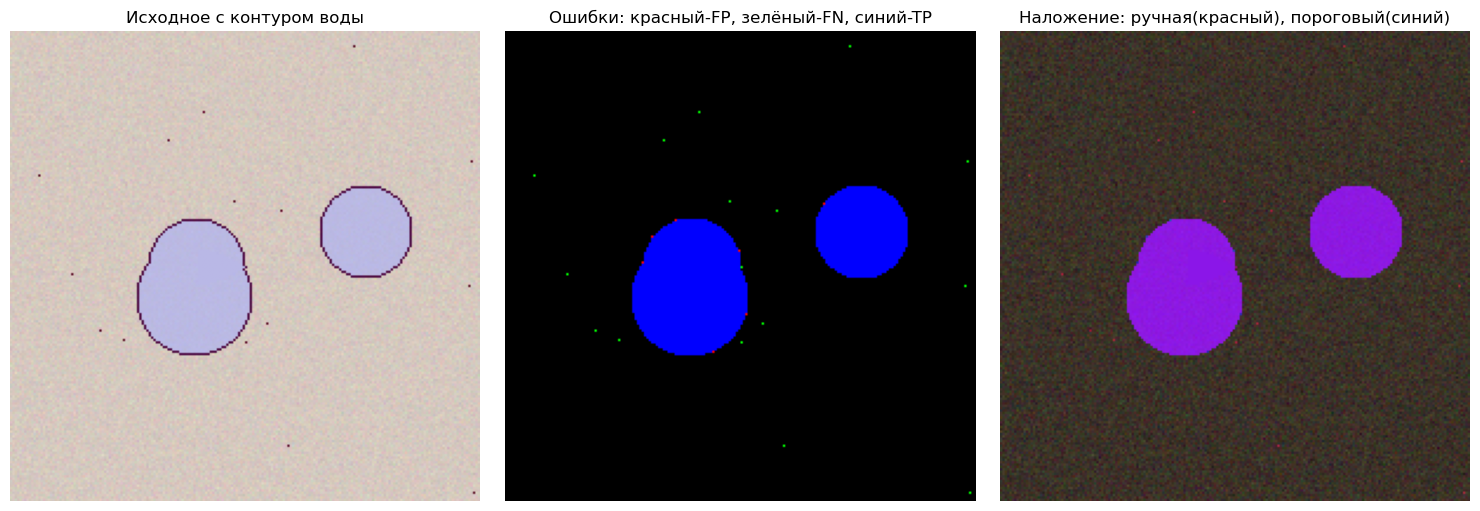


ВЫВОДЫ:
1. K-means кластеризация хорошо выделяет спектрально различные объекты
2. Простая пороговая сегментация работает быстрее, но хуже на сложных границах
3. Основные ошибки возникают на границах объектов и в тенях
4. Для улучшения качества можно:
   - Использовать больше спектральных каналов
   - Добавить текстурные признаки
   - Применить морфологическую пост-обработку


In [13]:
# 6. ВИЗУАЛИЗАЦИЯ


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Исходное изображение
axes[0, 0].imshow(img)
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

# K-means кластеры
axes[0, 1].imshow(labels_kmeans, cmap='tab10', vmin=0, vmax=3)
axes[0, 1].set_title('K-means кластеры (4)')
axes[0, 1].axis('off')

# Разность каналов для порога
axes[0, 2].imshow(blue_minus_red, cmap='RdBu')
axes[0, 2].set_title('Разность (синий - красный)')
axes[0, 2].axis('off')
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

# Ручная маска
axes[1, 0].imshow(manual_mask, cmap='Blues')
axes[1, 0].set_title('Ручная маска (вода)')
axes[1, 0].axis('off')

# K-means вода
axes[1, 1].imshow(kmeans_water, cmap='Blues')
axes[1, 1].set_title(f'K-means вода\nIoU={iou_kmeans:.3f}, Acc={accuracy_kmeans:.3f}')
axes[1, 1].axis('off')

# Пороговая сегментация
axes[1, 2].imshow(threshold_final, cmap='Blues')
axes[1, 2].set_title(f'Пороговая сегментация\nIoU={iou_threshold:.3f}, Acc={accuracy_threshold:.3f}')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 7. АНАЛИЗ ОШИБОК
# ============================================

# Ошибки для лучшего метода
best_mask = kmeans_water if iou_kmeans > iou_threshold else threshold_final
best_name = "K-means" if iou_kmeans > iou_threshold else "пороговый"

false_positives = best_mask & ~manual_mask.astype(bool)
false_negatives = ~best_mask & manual_mask.astype(bool)

print("\n" + "="*60)
print(f"АНАЛИЗ ОШИБОК для метода {best_name}")
print("="*60)
print(f"Ложноположительные пиксели: {np.sum(false_positives)} ({np.sum(false_positives)/manual_mask.size*100:.2f}%)")
print(f"Ложноотрицательные пиксели: {np.sum(false_negatives)} ({np.sum(false_negatives)/manual_mask.size*100:.2f}%)")

# Визуализация ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Исходное с контурами
axes[0].imshow(img)
axes[0].set_title('Исходное с контуром воды')
# Добавляем контур ручной маски
from scipy.ndimage import binary_erosion
contour = manual_mask & ~binary_erosion(manual_mask)
axes[0].imshow(contour, cmap='Reds', alpha=0.7)
axes[0].axis('off')

# Ошибки
error_map = np.zeros((h, w, 3), dtype=np.uint8)
error_map[..., 0] = false_positives * 255  # FP - красный
error_map[..., 1] = false_negatives * 255  # FN - зелёный
error_map[..., 2] = (best_mask & manual_mask.astype(bool)) * 255  # TP - синий

axes[1].imshow(error_map)
axes[1].set_title('Ошибки: красный-FP, зелёный-FN, синий-TP')
axes[1].axis('off')

# Сравнение
axes[2].imshow(img)
overlay = np.zeros((h, w, 4))
overlay[manual_mask > 0, 0] = 1  # красный канал для ручной
overlay[best_mask > 0, 2] = 1    # синий канал для предсказания
overlay[..., 3] = 0.5  # прозрачность
axes[2].imshow(overlay)
axes[2].set_title(f'Наложение: ручная(красный), {best_name}(синий)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ВЫВОДЫ:")
print("="*60)
print("1. K-means кластеризация хорошо выделяет спектрально различные объекты")
print("2. Простая пороговая сегментация работает быстрее, но хуже на сложных границах")
print("3. Основные ошибки возникают на границах объектов и в тенях")
print("4. Для улучшения качества можно:")
print("   - Использовать больше спектральных каналов")
print("   - Добавить текстурные признаки")
print("   - Применить морфологическую пост-обработку")